### import

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import json

import cv2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

### jsontoframe

In [2]:
def jsontoframe(datapath):
    coco = COCO(datapath)

    train_df = pd.DataFrame()

    image_ids = []
    class_name = []
    class_id = []
    x_min = []
    y_min = []
    x_max = []
    y_max = []
    classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", 
            "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
    for image_id in coco.getImgIds():
            
        image_info = coco.loadImgs(image_id)[0]
        ann_ids = coco.getAnnIds(imgIds=image_info['id'])
        anns = coco.loadAnns(ann_ids)
            
        file_name = image_info['file_name']
            
        for ann in anns:
            image_ids.append(file_name)
            class_name.append(classes[ann['category_id']])
            class_id.append(ann['category_id'])
            x_min.append(float(ann['bbox'][0]))
            y_min.append(float(ann['bbox'][1]))
            x_max.append(float(ann['bbox'][0]) + float(ann['bbox'][2]))
            y_max.append(float(ann['bbox'][1]) + float(ann['bbox'][3]))

    train_df['image_id'] = image_ids
    train_df['class_name'] = class_name
    train_df['class_id'] = class_id
    train_df['x_min'] = x_min
    train_df['y_min'] = y_min
    train_df['x_max'] = x_max
    train_df['y_max'] = y_max
    
    return train_df

### data init

In [3]:
TRAIN_PATH = './dataset/train.json'
with open(TRAIN_PATH) as f: data = json.load(f)

df = jsontoframe(TRAIN_PATH)

LABELS = ["General trash", "Paper", "Paper pack", "Metal", "Glass", 
            "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


### RGB 시각화

In [4]:
g = df.groupby('class_name', group_keys=False)

rgb_dict = {}
for name, df_g in g:
    rgb_dict[name] = {'r': [], 'g': [], 'b': []}
    for data in df_g.itertuples():
        img = cv2.imread(os.path.join('./dataset', data.image_id))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # # H W C
        y_min, y_max, x_min, x_max = int(data.y_min), int(data.y_max), int(data.x_min), int(data.x_max)
        r_mean = np.mean(img[y_min:y_max,x_min:x_max,0])
        g_mean = np.mean(img[y_min:y_max,x_min:x_max,1])
        b_mean = np.mean(img[y_min:y_max,x_min:x_max,2])
        rgb_dict[name]['r'].append(r_mean)
        rgb_dict[name]['g'].append(g_mean)
        rgb_dict[name]['b'].append(b_mean)

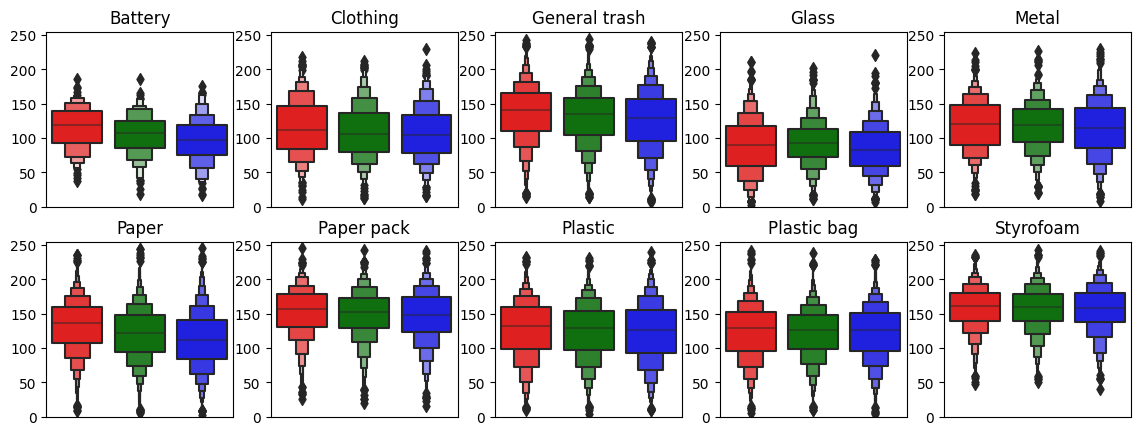

In [5]:
fig, ax = plt.subplots(nrows= 2, ncols=5, figsize=(14,5))
for i, (name, rgb) in enumerate(rgb_dict.items()):
    tmp = pd.DataFrame.from_dict(rgb)
    my_pal = {'r': 'r', 'g': 'g', 'b': 'b'}
    sns.boxenplot(data=tmp, palette=my_pal, ax=ax[int(i/5),int(i%5)])
    ax[int(i/5),int(i%5)].axes.xaxis.set_visible(False)
    ax[int(i/5),int(i%5)].set_title(f'{name}')
    ax[int(i/5),int(i%5)].set_ylim(0, 255)
# plt.show()

In [7]:
for i, (name, rgb) in enumerate(rgb_dict.items()):
    img = np.zeros([64,64,3])
    r_m,g_m,b_m = np.mean(rgb['r']),np.mean(rgb['g']),np.mean(rgb['b'])
    
    img[:,:,0] = np.ones([64,64])*int(b_m)
    img[:,:,1] = np.ones([64,64])*int(g_m)
    img[:,:,2] = np.ones([64,64])*int(r_m)
    cv2.imwrite(f'{name}_img.jpg', img)    

In [8]:
rgb_result = dict()
for i, (name, rgb) in enumerate(rgb_dict.items()):
    img = np.zeros([64,64,3])
    r_m,g_m,b_m = np.mean(rgb['r']),np.mean(rgb['g']),np.mean(rgb['b'])
    rgb_result[name] = [r_m,g_m,b_m]

with open('rgb.json', 'w') as outfile:
    json.dump(rgb_result, outfile, indent=4)

In [9]:
with open('rgb_all.json', 'w') as outfile:
    json.dump(rgb_dict, outfile, indent=4)